### MIT Micromasters in Supply Chain Management
This notebook uses the questions and models from the MIT Micromasters course materials, therefore all rights belongs to MIT. I have implemented the models in python.
For more details refer to https://www.edx.org/course/supply-chain-design

## Transhipment Problem
Transhipment problem is a subgroup of transportation problem, where transhipment.Here also we are trying to minimze the transport cost of distributing products from number of sources to destinations/markets through intermediate nodes.
This notebook builds a solution for transhipment problem with Pyomo library.


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyomo.environ import *

In [187]:
Supply = {      # Supply nodes
    'P1':100,
    'P2':125
}

Demand = {      # Demand nodes
    'R1':25,
    'R2':95,
    'R3':80
}

Centers = ['C1','C2']  # Transhipment nodes

Inbound = {
    ('P1','C1') : 190,
    ('P1','C2')  : 210,
    ('P2','C1') : 185,
    ('P2','C2')  : 105,
}

Outbound = {
    ('C1','R1') : 175,
    ('C1','R2')  : 180,
    ('C1','R3')   : 165,
    ('C2','R1') : 235,
    ('C2','R2')  : 130,
    ('C2','R3')   : 145
}

Distance = {
    ('P1','R1') : 250,
    ('P1','R2')  : 325,
    ('P1','R3')   : 445,
    ('P2','R1') : 275,
    ('P2','R2')  : 260,
    ('P2','R3')   : 460
}


UnitCost = 1

In [194]:
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

model.i = Set(initialize=Supply.keys(), doc='Plants')
model.j = Set(initialize=Demand.keys(), doc='Regions')
model.k = Set(initialize=Centers, doc='Transhipment')

model.di = Param(model.i, model.k, initialize=Inbound, doc='Inbound distance in miles')
model.do = Param(model.k, model.j, initialize=Outbound, doc='Outbounf distance in miles')
model.f = Param(initialize=UnitCost, doc='Freight cost in dollars per mile')

# Function to calculate inbound cost 
def c_init_inbound(model, i, k):
  return model.f * model.di[i,k]

model.ci = Param(model.i, model.k, initialize=c_init_inbound, doc='Inbound transport cost in dollar per case')

# Function to calculate outbound cost 
def c_init_outbound(model, k, j):
  return model.f * model.do[k,j]

model.co = Param(model.k, model.j, initialize=c_init_outbound, doc='Outbound transport cost in dollar per case')

# Initialize inbound flow on arc as a variable
model.xi = Var(model.i, model.k, bounds=(0.0,None),domain = NonNegativeReals, doc='Inbound shipment quantities')

# Initialize outbound flow on arc as a variable
model.xo = Var(model.k, model.j, bounds=(0.0,None),domain = NonNegativeReals, doc='Outbound shipment quantities')

# Function to get objective function rule
def objective_rule(model):
  return sum(model.ci[i,k]*model.xi[i,k] for i in model.i for k in model.k) + sum(model.co[k,j]*model.xo[k,j] for k in model.k for j in model.j)

model.cost = Objective(rule=objective_rule, sense=minimize, doc='Total cost')

#Define constraints
def supply_rule(model, i):
  return sum(model.xi[i,k] for k in model.k) <= Supply[i]
model.supply = Constraint(model.i, rule=supply_rule, doc='Observe supply limit at plant i')

def demand_rule(model, j):
  return sum(model.xo[k,j] for k in model.k) >= Demand[j]  
model.demand = Constraint(model.j, rule=demand_rule, doc='Satisfy demand at market j')

def flow_balance_rule(model, k):
  return sum(model.xi[i,k] for i in model.i) == sum(model.xo[k,j] for j in model.j) 
model.balanceflow = Constraint(model.k, rule=flow_balance_rule, doc='Balance flow at intermediate nodes k')

#Solve the model with GLPK solver
results = SolverFactory('glpk').solve(model)


In [195]:
ri = []
ro = []

if 'ok' == str(results.Solver.status):
    print("Total Shipping Costs = ",model.cost())
    for i in model.i:
        for k in model.k:
                if model.xi[i,k]() > 0:
                    ri.append((i,k,model.xi[i,k](),model.di[i,k],model.ci[i,k]))
                
    result_df_inbound = pd.DataFrame(ri, columns=['Origin','Destination','Flow','Distance','Cost'])
    
    for k in model.k:
        for j in model.j:
                if model.xo[k,j]() > 0:
                    ro.append((k,j,model.xo[k,j](),model.do[k,j],model.co[k,j]))
                
    result_df_outbound = pd.DataFrame(ro, columns=['Origin','Destination','Flow','Distance','Cost'])
    
    result_df = pd.concat([result_df_inbound,result_df_outbound])
else:
    print("No Valid Solution Found")

Total Shipping Costs =  56700.0


### Optimized resuts

In [196]:
result_df

,Origin,Destination,Flow,Distance,Cost
0,P2,C2,125.0,105,105
1,P1,C1,75.0,190,190
0,C2,R3,30.0,145,145
1,C2,R2,95.0,130,130
2,C1,R1,25.0,175,175
3,C1,R3,50.0,165,165


## Visualize network solution

In [197]:
def draw_graph(flow, plants, regions, dcs,distance):
    # create networkx graph
    G=nx.DiGraph()
    
    # add nodes
    G.add_nodes_from(regions, s="o")
    G.add_nodes_from(dcs, s="^")
    G.add_nodes_from(plants, s=",")    
    
    plant_color = []
    market_color = []
    dc_color = []
    
    for i in plants:
        plant_color.append('orange')

    for j in regions:
        market_color.append('blue')
        
    for k in dcs:
        dc_color.append('red')
    
    # add edges
    G.add_edges_from(flow)
    graph_pos = nx.kamada_kawai_layout(G,dist=distance)
    
    nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))
    
    #For each node class...
    for aShape in nodeShapes:
        if aShape == ',':
            color_map = plant_color
        elif aShape == 'o':
            color_map = market_color
        else:
            color_map = dc_color
            
        nx.draw_networkx_nodes(G,graph_pos,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],node_size=1000, node_color=color_map, alpha=0.3)
    
    nx.draw_networkx_edges(G, graph_pos, width=2, alpha=0.3, edge_color='green')
    nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')
    
    plt.axis('off')
    plt.show()

In [198]:
flow = result_df[['Origin','Destination']].values.tolist()
plants = Supply.keys()
regions = Demand.keys()
dcs = Centers
distance = result_df['Distance'].to_dict()

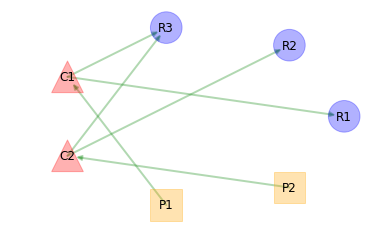

In [199]:
draw_graph(flow,plants,regions,dcs,distance)

## Sensitivity Analysis
### Analysis by plant

In [200]:
s = []
for i in model.i:
    s.append((i,Supply[i],model.supply[i](),model.dual[model.supply[i]]))
    
supply_sensitivity = pd.DataFrame(s, columns=['Plant','Capacity','Utilized','Marginal_cost'])
supply_sensitivity

,Plant,Capacity,Utilized,Marginal_cost
0,P2,125,125.0,-105.0
1,P1,100,75.0,0.0


### Analysis by market

In [201]:
d = []
for j in model.j:
    d.append((j,Demand[j],model.demand[j](),model.dual[model.demand[j]]))
    
supply_sensitivity = pd.DataFrame(d, columns=['Region','Demand','Fullfiled','Marginal_cost'])
supply_sensitivity

,Region,Demand,Fullfiled,Marginal_cost
0,R1,25,25.0,365.0
1,R3,80,80.0,355.0
2,R2,95,95.0,340.0
